In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR

In [0]:
df = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [0]:
spare = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [4]:
df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,8-Mar-19,Hurricanes,Highlanders,0.0,0.0,1.29,24.79,3.68,11.0
1,8-Mar-19,Rebels,Brumbies,0.0,0.0,1.57,21.82,2.46,11.0
2,9-Mar-19,Crusaders,Chiefs,0.0,0.0,1.15,30.29,5.49,10.0
3,9-Mar-19,Blues,Sunwolves,0.0,0.0,1.16,30.49,5.23,10.0
4,9-Mar-19,Waratahs,Reds,0.0,0.0,1.32,25.18,3.44,10.0
5,9-Mar-19,Lions,Jaguares,0.0,0.0,1.28,24.44,3.77,10.0
6,9-Mar-19,Bulls,Sharks,0.0,0.0,1.53,21.68,2.55,10.0


### Get win streak

In [0]:
def bool_to_int(bool_val):
    if bool_val:
        return 1
    else:
        return -1

def get_home_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Home Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try: 
        last_result = bool_to_int(next(results)[-1])
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak
        

def get_away_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Away Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try:
        last_result = bool_to_int(next(results)[-1])*-1
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])*-1
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak

### Cleaning and Feature Engineering

In [0]:
countries = {'Crusaders': 'NZ',
             'Chiefs': 'NZ',
             'Blues': 'NZ',
             'Hurricanes': 'NZ',
             'Highlanders': 'NZ',
             'Bulls': 'SA',
             'Cheetahs': 'SA',
             'Kings': 'SA',
             'Lions': 'SA',
             'Sharks': 'SA',
             'Stormers': 'SA',
             'Brumbies': 'AUS',
             'Force': 'AUS',
             'Rebels': 'AUS',
             'Reds': 'AUS',
             'Waratahs': 'AUS',
             'Jaguares': 'ARG',
             'Sunwolves': 'JPN'}

def cleanup(df):
    
    # convert Date to datetime
    df['Date'] = pd.to_datetime(df.Date)
    
    # create response variable
    df['home_margin'] = df['Home Score'] - df['Away Score']
    
    # create home_win column
    df['home_win'] = (df['Home Score'] > df['Away Score'])
    
    df.drop(['Home Score', 'Away Score'], axis=1, inplace=True)
    
    # create home_streak and away_streak columns
    home_streaks = []
    away_streaks = []
    for row in df.itertuples():
        home_team = row[2]
        away_team = row[3]
        date = row[1]
        home_streaks.append(get_home_streak(home_team, date))
        away_streaks.append(get_away_streak(away_team, date))
        
    df['home_streak'] = home_streaks
    df['away_streak'] = away_streaks
    
    # add nationalities
    df['home_nationality'] = df['Home Team'].replace(countries)
    df['away_nationality'] = df['Away Team'].replace(countries)
    
    # encode nationalities
    df = pd.get_dummies(df, prefix='home_country', columns=['home_nationality'])
    df = pd.get_dummies(df, prefix='away_country', columns=['away_nationality'])
    
    # encode team names
    df = pd.get_dummies(df, prefix='home_team', columns=['Home Team'])
    df = pd.get_dummies(df, prefix='away_team', columns=['Away Team'])
    
    # aggregate odds into single probability variable
    df['home_odds'] = df['Away Odds'] / (df['Home Odds'] + df['Away Odds'])
    
    # drop irrelevent columns
    df.drop(['Date', 'Home Odds', 'Draw Odds', 'Away Odds', 'Bookmakers Surveyed'], 
            axis=1,
            inplace=True)
    
    return df

In [8]:
df = cleanup(df)
df.head(15)

,home_margin,home_win,home_streak,away_streak,home_country_ARG,home_country_AUS,home_country_JPN,home_country_NZ,home_country_SA,away_country_ARG,...,away_team_Jaguares,away_team_Kings,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs,home_odds
0,0.0,False,11,-1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.740443
1,0.0,False,1,-1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.610422
2,0.0,False,21,-2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.826807
3,0.0,False,-1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0.818466
4,0.0,False,-1,-7,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.722689
5,0.0,False,-1,-3,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0.746535
6,0.0,False,2,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0.625000
7,-15.0,False,-1,-23,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0.921613
8,-10.0,False,2,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.179128
9,-18.0,False,5,-5,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.694013


In [0]:
import seaborn as sns

In [0]:
sns.scatterplot(x='home_odds', y='home_margin', data=df)

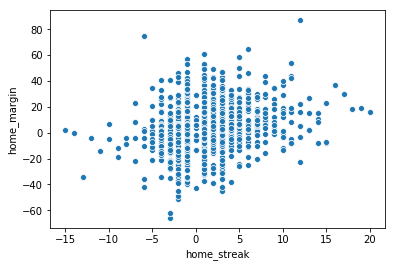

In [0]:
sns.scatterplot(x='home_streak', y='home_margin', data=df)

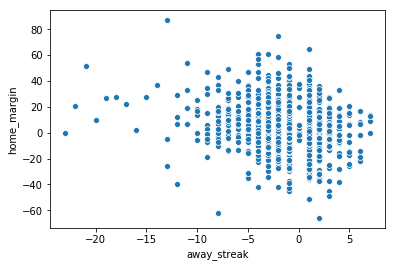

In [0]:
sns.scatterplot(x='away_streak', y='home_margin', data=df)

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
home_margin,1234.0,4.494327,17.329788,-66.000000,-6.000000,4.000000,15.000000,87.000000
home_streak,1234.0,1.194489,3.819033,-15.000000,-1.000000,1.000000,3.000000,21.000000
away_streak,1234.0,-1.154781,3.419025,-23.000000,-3.000000,-1.000000,1.000000,7.000000
home_country_ARG,1234.0,0.021070,0.143675,0.000000,0.000000,0.000000,0.000000,1.000000
home_country_AUS,1234.0,0.298217,0.457661,0.000000,0.000000,0.000000,1.000000,1.000000
home_country_JPN,1234.0,0.020259,0.140943,0.000000,0.000000,0.000000,0.000000,1.000000
home_country_NZ,1234.0,0.329011,0.470045,0.000000,0.000000,0.000000,1.000000,1.000000
home_country_SA,1234.0,0.331442,0.470923,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_ARG,1234.0,0.020259,0.140943,0.000000,0.000000,0.000000,0.000000,1.000000
away_country_AUS,1234.0,0.298217,0.457661,0.000000,0.000000,0.000000,1.000000,1.000000


### TO DO: Include some sort of form factor
Would like to create a function that finds the last 5 fixtures for each team, or something along those lines.

In [0]:
X = df.drop(['home_margin', 'home_win'], axis=1)
y = df.home_margin

## Model Preparation: Random Forest Regressor

To do:

- Train/test split
- Set up random forest
- Train
- Check test accuracy
- Predict with week 2 data

In [0]:
# set up train/test split with 80/20 proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
# random forest regressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)

In [15]:
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [16]:
pd.DataFrame(np.vstack((X_train.columns.values,rf.feature_importances_))).T

,0,1
0,home_streak,0.0974799
1,away_streak,0.0933551
2,home_country_ARG,0.00239158
3,home_country_AUS,0.00983508
4,home_country_JPN,0.00372369
5,home_country_NZ,0.00911398
6,home_country_SA,0.00876433
7,away_country_ARG,0.00135105
8,away_country_AUS,0.00822745
9,away_country_JPN,0.0029118


In [17]:
# Use the forest's predict method on the test data
np.sqrt(mean_squared_error(rf.predict(X_test), y_test))

16.912477919947527

In [18]:
mean_absolute_error(y_test, rf.predict(X_test))

12.702688259109314

In [0]:
# create the grid
n_estimators = [200, 500, 1000]
max_depth = [None, 5, 6, 7, 8, 9]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

In [0]:
from sklearn.metrics import make_scorer

In [21]:
# create the default model
rf = RandomForestRegressor(random_state=42)

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    scoring=make_scorer(mean_squared_error),
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   57.6s finished


In [22]:
# summarize results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

240.100797 (2.652504) with: {'max_depth': None, 'n_estimators': 200}
239.388736 (3.448674) with: {'max_depth': None, 'n_estimators': 500}
238.399459 (4.311552) with: {'max_depth': None, 'n_estimators': 1000}
216.491920 (5.257843) with: {'max_depth': 5, 'n_estimators': 200}
215.928758 (5.740943) with: {'max_depth': 5, 'n_estimators': 500}
215.827941 (6.098925) with: {'max_depth': 5, 'n_estimators': 1000}
220.538715 (5.506046) with: {'max_depth': 6, 'n_estimators': 200}
219.314347 (5.988077) with: {'max_depth': 6, 'n_estimators': 500}
218.926672 (6.141874) with: {'max_depth': 6, 'n_estimators': 1000}
223.524371 (4.821832) with: {'max_depth': 7, 'n_estimators': 200}
222.409837 (5.416222) with: {'max_depth': 7, 'n_estimators': 500}
221.898566 (5.862315) with: {'max_depth': 7, 'n_estimators': 1000}
225.789461 (5.079626) with: {'max_depth': 8, 'n_estimators': 200}
224.903701 (5.192042) with: {'max_depth': 8, 'n_estimators': 500}
224.464482 (5.732452) with: {'max_depth': 8, 'n_estimators': 10

In [23]:
# create the grid
leaf_samples = [5, 10, 15, 20, 25, 30, 50, 100]
param_grid = dict(min_samples_leaf=leaf_samples)

# create the model with new max_depth and n_estimators
rf = RandomForestRegressor(n_estimators=1000, 
                           max_depth=5,
                           random_state=42)

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    scoring=make_scorer(mean_squared_error),
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   25.3s finished


In [24]:
# summarize results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

213.631738 (6.212777) with: {'min_samples_leaf': 5}
211.232229 (6.720186) with: {'min_samples_leaf': 10}
210.903619 (6.900886) with: {'min_samples_leaf': 15}
210.069085 (7.017929) with: {'min_samples_leaf': 20}
209.003137 (7.041992) with: {'min_samples_leaf': 25}
208.054360 (7.313764) with: {'min_samples_leaf': 30}
205.877072 (10.561085) with: {'min_samples_leaf': 50}
211.534042 (15.202055) with: {'min_samples_leaf': 100}


In [25]:
# create the grid
max_features = ['sqrt', 'log2', None]
bootstrap = [True, False]
param_grid = dict(max_features=max_features, bootstrap=bootstrap)

# create the model with new max_depth and n_estimators
rf = RandomForestRegressor(n_estimators=1000, 
                           max_depth=5,
                           min_samples_leaf=30,
                           random_state=42)

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    scoring=make_scorer(mean_squared_error),
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   14.7s finished


In [26]:
# summarize results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

234.858709 (19.680726) with: {'bootstrap': True, 'max_features': 'sqrt'}
246.673802 (21.316477) with: {'bootstrap': True, 'max_features': 'log2'}
208.054360 (7.313764) with: {'bootstrap': True, 'max_features': None}
228.018427 (19.445242) with: {'bootstrap': False, 'max_features': 'sqrt'}
234.972943 (20.015020) with: {'bootstrap': False, 'max_features': 'log2'}
217.868886 (10.547085) with: {'bootstrap': False, 'max_features': None}


## Make predictions for upcoming week

In [0]:
X_temp = X[:7]
y_temp = y[:7]

In [56]:
# train model
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=30, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [57]:
np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))

16.27440952251231

In [58]:
mean_absolute_error(y_test, rf.predict(X_test))

12.238547847459865

In [59]:
# predict for upcoming week
np.vstack((rf.predict(X_temp), spare['Home Team'][:7], spare['Away Team'][:7])).T

array([[8.523297550757071, 'Hurricanes', 'Highlanders'],
       [3.3270172488511567, 'Rebels', 'Brumbies'],
       [13.110814670134946, 'Crusaders', 'Chiefs'],
       [13.986388999998816, 'Blues', 'Sunwolves'],
       [8.090016690339032, 'Waratahs', 'Reds'],
       [8.010891554030216, 'Lions', 'Jaguares'],
       [5.4459996529115395, 'Bulls', 'Sharks']], dtype=object)

In [0]:
temp = np.vstack((rf.predict(X_temp), spare['Home Team'][:7], spare['Away Team'][:7])).T

In [0]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [62]:
preds_df["Home_Margin"] = preds_df.Home_Margin.astype(int)
preds_df

,Home_Margin,Home_Team,Away_Team
0,8,Hurricanes,Highlanders
1,3,Rebels,Brumbies
2,13,Crusaders,Chiefs
3,13,Blues,Sunwolves
4,8,Waratahs,Reds
5,8,Lions,Jaguares
6,5,Bulls,Sharks
